<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_5_FCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This file is loosely inspired by the tutorial based on:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>

Some of the code in this file is generated by ChatGPT

This file makes use of the MIT-BIH Database

# Dependencies

In [118]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import wfdb

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

import time
import csv
import os
import random

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

# Load the dataset

The MIT-BIH dataset contains 48 half-hour samples of ECG recordings

Each recording corresponds to three raw files:

1. `.hea` describes the recording's sampling rate, channels, etc.
2. `.dat` are a sequence of 12-bit integers encoding the intensity at 360 Hz with a resolution of 1/200 mV
    - there are two channels, but only the first one is consistent
3. `.atr` includes the time stamp and type of each heartbeat

In [119]:
dl_path = "./raw_data/"
# set records to be included here
recordNames = [100, 101, 102, 103, 104, 105, 106, 107, 108, 109]
recordNames = [102, 100, 102]
# window size for each record
windowSize = 360

batch_size = 128
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")

In [120]:
numRec = len(recordNames)

for i in range(numRec):
    recordNames[i] = str(recordNames[i])

print("Number of records: %d" % numRec)

Number of records: 3


# Read the files

The `.dat` file's encoding is automatically converted to double floats in mV when we read it

The `.atr` is read into an object with an array of true labels and an array of time stamps

In [121]:
annos = [] # annotation
records = []

for i in range(numRec):
    annos.append(wfdb.rdann(dl_path + recordNames[i], 'atr'))
    records.append(wfdb.rdrecord(dl_path + recordNames[i]))

print(len(annos[i].sample), len(annos[i].symbol))
    
signals = []
for i in range(numRec):
    # we'll worry about quantization later in the code
    signals.append(records[i].p_signal.astype(np.float32))

2192 2192


## Heartbeat Segmentation

We want each heartbeat in the records to be one data point, those data points should then be shuffled (instead of being grouped by patient)

In [122]:
beats = []
labelChars = [] # label still in strings
for i in range(numRec):
    for pos, label in zip(annos[i].sample, annos[i].symbol):
        winMin = pos - windowSize//2
        winMax = pos + windowSize//2
        if (winMin >=0 and winMax <= len(signals[i])): # this will sacrifice some signals
            segment = signals[i][pos - windowSize//2 : pos + windowSize//2, 0] # channel 0 only
            beats.append(segment)
            labelChars.append(label)

beats = np.stack(beats) # shape: total number of beats * window size
print("Shape of beats:", len(beats), len(beats[0]))

Shape of beats: 6649 360


AAMI suggests five categories out of the multitude of labels from MIT-BIH, we encode them into integers

In [123]:
# N:0 S:1 V:2 F:3 Q:4; 4 is unclassifiable
labelMap = {
    'N':0,'L':0,'R':0,'e':0,'j':0,
    'A':1,'a':1,'J':1,'S':1,
    'V':2,'E':2,
    'F':3,
    'Q':4,'/':4,'?':4,'f':4,'P':4,'t':4
}

for l in labelChars:
    if l not in labelMap:
        print(l)
labels = [labelMap.get(_x, 4) for _x in labelChars]
print(set(labels))

+
+
+
+
+
+
+
+
{0, 1, 2, 4}


## Torch Dataset and Loader

In [124]:
class MB_Dataset(Dataset):
    def __init__(self, beatsT, labelsT, t=torch.float32):
        self.beats = torch.tensor(beatsT, dtype=t) # now we quantize
        self.labels = torch.tensor(labelsT, dtype=torch.long)
    def __len__(self):
        return len(self.beats)
    def __getitem__(self, idx):
        return self.beats[idx], self.labels[idx]
    def shapes(self):
        print(self.beats.shape, self.labels.shape)

dataset = MB_Dataset(beats, labels)
dataset.shapes()

torch.Size([6649, 360]) torch.Size([6649])


In [125]:
from torch.utils.data import random_split

# Example: 80% train, 20% test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

## Data Visualisation

In [126]:
def plot_spikes(spike_data, k=1):
    fig = plt.figure(facecolor="w", figsize=(8, 1))
    ax = fig.add_subplot(111)
    splt.raster(spike_data, ax, c="black")
    plt.title("Input Neuron")
    plt.xlabel("Time step")
    plt.yticks([])
    plt.xlim(0, windowSize*k)
    plt.show()

def plot_beat(data):
    plt.plot(data)

    plt.title("beat")
    plt.xlabel("Time step")
    plt.ylabel("Voltage (mV)")
    plt.show()

-----
showcasing sample 1762
truth class: tensor(4)


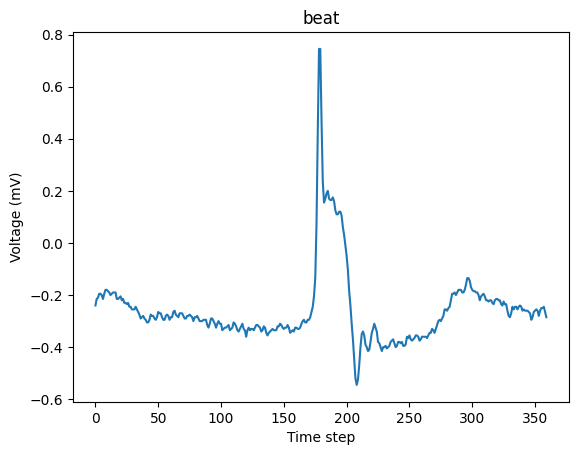

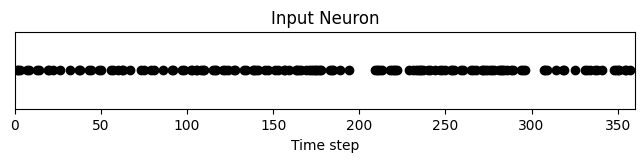

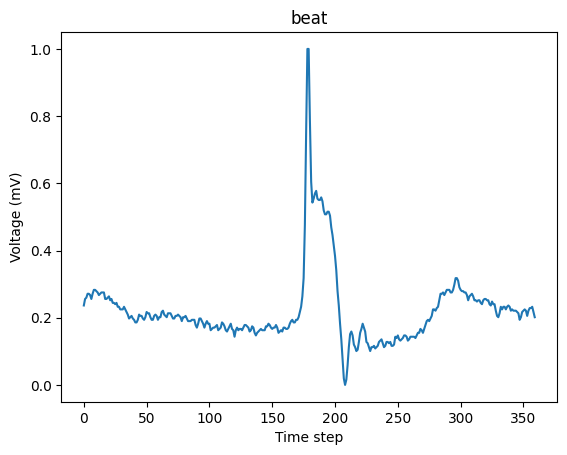

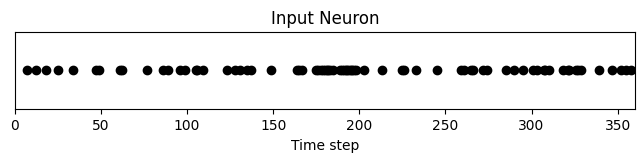

In [127]:
for i in range(1):
    print("-----")
    
    ri = random.randint(0, len(dataset))
    
    print("showcasing sample", ri)
    print("truth class:", dataset[ri][1])

    beat = dataset[ri][0]

    plot_beat(beat)

    spikeData = spikegen.delta(beat, threshold=0.003)
    plot_spikes(spikeData)
    
    # to create a spike train, we repeat every sample multiple times
    k = 1
    if (k > 1):
        beat = beat.unsqueeze(-1).repeat(1, k).view(-1)
    # normalise
    beat = (beat - beat.min()) / (beat.max() - beat.min())
    plot_beat(beat)
    spikeData = spikegen.rate(beat, time_var_input=True)
    plot_spikes(spikeData, k=k)

    
                

# Define the Network(s)

## SNN_Baseline

In [128]:
# accepts a tensor of num_steps×batchx1
class SNN_Baseline(nn.Module):
    def __init__(self, beta=0.95):
        super().__init__()
        self.name = "SNN_Baseline"
        
        # Temporal Dynamics
        self.beta = beta
        
        # Network Architecture
        num_inputs = 1 # only one input neuron
        num_outputs = 5 # five classes

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, 128)
        self.lif1 = snn.Leaky(beta=self.beta)
        self.fc2 = nn.Linear(128, 64)
        self.lif2 = snn.Leaky(beta=self.beta)
        self.fc3 = nn.Linear(64, num_outputs)
        self.lif3 = snn.Leaky(beta=self.beta)

    def forward(self, x, num_steps):
        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        
        # Record the final layer
        spkx_rec = []
        memx_rec = []

        for step in range(num_steps):
            # Feed in the voltages of the entire batch at a given time step in parallel
            cur1 = self.fc1(x[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)
            spkx_rec.append(spk3)
            memx_rec.append(mem3)

        return torch.stack(spkx_rec, dim=0), torch.stack(memx_rec, dim=0)

# Evaluation Functions

In [129]:
def plot_loss(loss_hist):
    fig = plt.figure(facecolor="w", figsize=(10, 5))
    plt.plot(loss_hist)
    plt.title("Loss Curves")
    plt.legend(["Train Loss", "Test Loss"])
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()

def evaluate(net, windowSize, spikeTrainSize, deltaThr):
    total = 0
    correct = 0

    deltaEn = deltaThr > 0

    num_steps = windowSize*spikeTrainSize
    
    # drop_last switched to False to keep all samples
    testLoader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

    totalLabels = []
    totalPredictions = []
    
    with torch.no_grad():
        net.eval()
        for data, targets in testLoader:
            data = data.to(device)
            targets = targets.to(device)
              
            if (not deltaEn): # we need to normalise for rate encoding
                dmin = data.min(dim=1, keepdim=True).values
                dmax = data.max(dim=1, keepdim=True).values
                data = (data-dmin) / (dmax-dmin)
            # to create a spike train, we repeat every sample multiple times
            if (spikeTrainSize > 1):
                dataS = data.unsqueeze(-1)
                dataS = dataS.repeat(1, 1, spikeTrainSize)
                data = dataS.view(-1, num_steps)
                
            # data is now batchx(num_steps), but we need it in (num_steps)xbatchx1 
            data = (data.unsqueeze(0)).permute(2, 1, 0)
            if (deltaEn):
                spikeData = spikegen.delta(data, threshold=deltaThr)
            else:
                spikeData = spikegen.rate(data, time_var_input=True)
            # spikeData should be in (num_steps)xbatchxinputs

            # forward pass
            test_spk, _ = net(spikeData, num_steps)
        
            #print(test_spk.sum(dim=0))
            # calculate total accuracy
            _, predicted = test_spk.sum(dim=0).max(1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
            totalLabels.append(targets)
            totalPredictions.append(predicted)
    
    print(f"Total correctly classified: {correct}/{total}")
    print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

    # Confusion Matrix
    truth = torch.cat(totalLabels)
    pred = torch.cat(totalPredictions)

    confusion_mat = confusion_matrix(truth.cpu(), pred.cpu())

    # Display the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat,
                annot=True,
                fmt="d",
                cmap="Blues",
                xticklabels=[f"Class {i}" for i in range(5)],
                yticklabels=[f"Class {i}" for i in range(5)])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    
    return correct / total



# The Training Function

In [130]:
def train_net(net, windowSize, spikeTrainSize, deltaThr, num_epochs):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

    # each sample in the window can generate multiple spikes for rate encoding
    num_steps = windowSize*spikeTrainSize

    deltaEn = (deltaThr > 0) # disable delta if the threshold is negative
    
    loss_hist = []
    counter = 0
    
    # Outer training loop
    for epoch in range(num_epochs):
        iter_counter = 0
        train_batch = iter(train_loader)
    
        # Minibatch training loop
        for data, targets in train_batch:
            # data is batchxwindowSize
            data = data.to(device)
            targets = targets.to(device)

            if (not deltaEn): # we need to normalise for rate encoding
                dmin = data.min(dim=1, keepdim=True).values
                dmax = data.max(dim=1, keepdim=True).values
                data = (data-dmin) / (dmax-dmin)

            # to create a spike train, we repeat every sample multiple times
            if (spikeTrainSize > 1):
                dataS = data.unsqueeze(-1)
                dataS = dataS.repeat(1, 1, spikeTrainSize)
                data = dataS.view(-1, num_steps)

            # data is now batchx(num_steps), but we need it in (num_steps)xbatchx1 
            data = (data.unsqueeze(0)).permute(2, 1, 0)
            
            if (deltaEn):
                spikeData = spikegen.delta(data, threshold=deltaThr, off_spike=True)
            else:
                spikeData = spikegen.rate(data, time_var_input=True)
            # spikeData should be in (num_steps)xbatchxinputs

            # sample plots
            if (random.randint(0, 10000) < 200) and True:
                dataP = data.clone().cpu().permute(2, 1, 0)
                b = random.randint(0, len(dataP[0])-1)
                plot_beat(dataP[0][b])
                plot_spikes(spikeData.clone().cpu().permute(2, 1, 0)[0][b])
            
            # forward pass
            net.train()
            spk_rec, mem_rec = net(spikeData, num_steps)

            # initialize the loss & sum over time
            loss_val = torch.zeros((1), dtype=torch.float32, device=device)
            for step in range(num_steps):
                loss_val += loss(mem_rec[step], targets)
    
            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
    
            # Store loss history for future plotting
            loss_hist.append(loss_val.item())

            counter += batch_size

            print("\rProgress %8d / %8d" % (counter, len(train_dataset)*num_epochs), end='', flush=True)
    return loss_hist
            

# Training Loop

In [131]:
# List of tuples of format (model, beta, spikeTrain, deltaThr, num_epochs)
hyperList = [
    (SNN_Baseline, 0.95, 1, 0.012, 2),
]

In [132]:
# cache
csv_file = 'hyper_result_cache.csv'
results = {}
if os.path.exists(csv_file):
    with open(csv_file, mode='r', newline='') as f:
        reader = csv.reader(f)
        for row in reader:
            key_str, result = row
            results[key_str] = result

Training for (<class '__main__.SNN_Baseline'>, 0.95, 1, 0.012, 2)
Progress     8576 /    10638

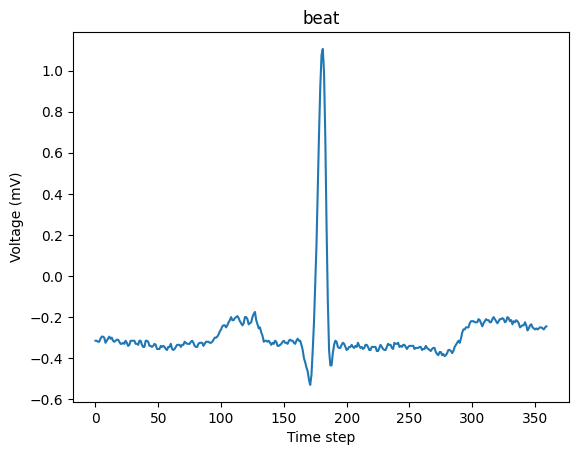

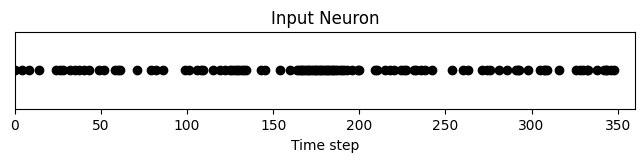

Progress     9984 /    10638

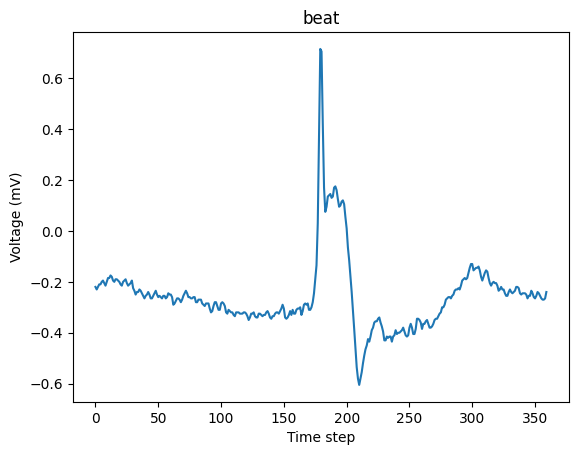

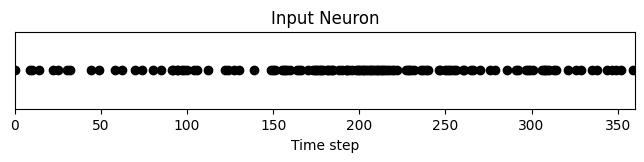

Progress    10496 /    10638
Finished, time elapsed 21.80 s


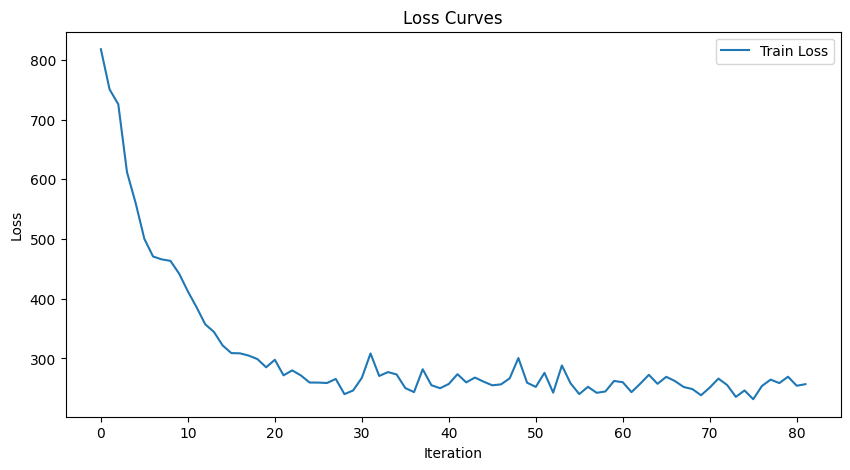

Total correctly classified: 813/1330
Test Set Accuracy: 61.13%


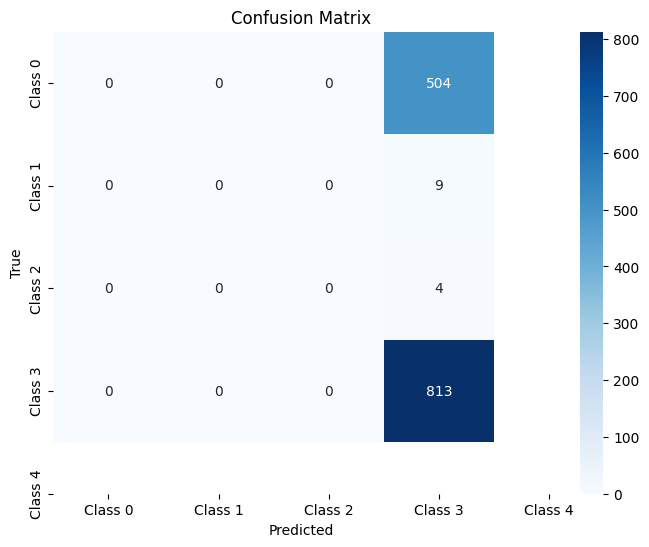

-----



In [133]:
for hyper in hyperList:

    shyper = str(hyper) + str(recordNames)
    if (shyper in results) and False:
        print("Cached hyper", hyper)
        print(f"Test Set Accuracy: {100 * float(results[shyper]):.2f}%")
        continue
        
    print("Training for", hyper)
    startTime = time.time()
    
    net = hyper[0](hyper[1])
    loss_hist = train_net(net = net.to(device),
                          windowSize = windowSize,
                          spikeTrainSize = hyper[2],
                          deltaThr = hyper[3],
                          num_epochs = hyper[4])

    print("\nFinished, time elapsed %.2f s" % (time.time()-startTime))
    plot_loss(loss_hist)
    accu = evaluate(net, windowSize, hyper[2], hyper[3])
    print("-----\n")

    with open(csv_file, mode='a', newline='') as f:
        writer = csv.writer(f)
        results[shyper] = accu
        writer.writerow([shyper, accu])

In [ ]:
results